<a href="https://colab.research.google.com/github/IA-UCSP-2020/Inteligencia-Artificial-/blob/master/Practica3_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import InputLayer

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5\
    -O /tmp/xception_notop.h5


--2020-07-13 00:27:34--  https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83683744 (80M) [application/octet-stream]
Saving to: ‘/tmp/xception_notop.h5’

/tmp/xception_notop 100%[===================>]  79.81M   127MB/s    in 0.6s    

2020-07-13 00:27:35 (127 MB/s) - ‘/tmp/xception_notop.h5’ saved [83683744/83683744]



In [ ]:
from tensorflow.keras.applications.xception import Xception

local_weights_file = '/tmp/xception_notop.h5'
pre_trained_model = Xception(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('layer',120)
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 9, 9, 1024)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [ ]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2020-07-13 00:56:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 2404:6800:4003:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  23.6MB/s    in 2.8s    

2020-07-13 00:56:55 (23.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
100/100 - 21s - loss: 1.0442 - acc: 0.8350 - val_loss: 0.2313 - val_acc: 0.9330
Epoch 2/2
100/100 - 20s - loss: 0.3567 - acc: 0.8950 - val_loss: 0.1041 - val_acc: 0.9570


In [ ]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
100/100 - 21s - loss: 0.1954 - acc: 0.9250 - val_loss: 0.0994 - val_acc: 0.9590
Epoch 2/50
100/100 - 20s - loss: 0.1986 - acc: 0.9285 - val_loss: 0.0974 - val_acc: 0.9600
Epoch 3/50
100/100 - 20s - loss: 0.2011 - acc: 0.9235 - val_loss: 0.0962 - val_acc: 0.9600
Epoch 4/50
100/100 - 20s - loss: 0.1859 - acc: 0.9340 - val_loss: 0.0966 - val_acc: 0.9600
Epoch 5/50
100/100 - 20s - loss: 0.2046 - acc: 0.9230 - val_loss: 0.0927 - val_acc: 0.9610
Epoch 6/50
100/100 - 20s - loss: 0.1710 - acc: 0.9340 - val_loss: 0.0906 - val_acc: 0.9620
Epoch 7/50
100/100 - 20s - loss: 0.2043 - acc: 0.9230 - val_loss: 0.0918 - val_acc: 0.9630
Epoch 8/50
100/100 - 19s - loss: 0.1797 - acc: 0.9345 - val_loss: 0.0903 - val_acc: 0.9620
Epoch 9/50
100/100 - 19s - loss: 0.1821 - acc: 0.9315 - val_loss: 0.0883 - val_acc: 0.9620
Epoch 10/50
100/100 - 20s - loss: 0.1753 - acc: 0.9335 - val_loss: 0.0896 - val_acc: 0.9620
Epoch 11/50
100/100 - 20s - loss: 0.1683 - acc: 0.9310 - val_loss: 0.0890 - val_acc: 0.96

Text(0.5, 1.0, 'Training and validation loss')

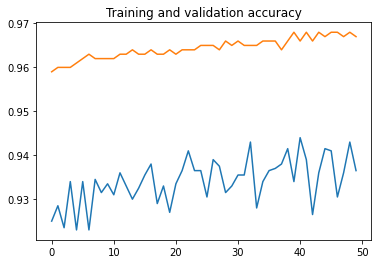

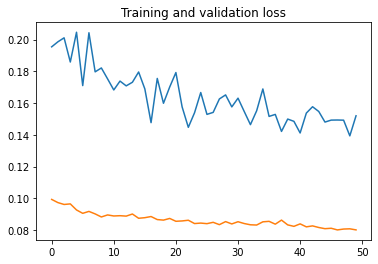

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)